#### Distribution synthetic high frequency signal

In [2]:
import xarray as xr
import numpy as np

from scipy import stats                                                         

import matplotlib.pyplot as plt
import seaborn as sns

import sstats.tseries as ts
import sstats.sigp as sigp

In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [4]:
sigma0 = xr.open_dataset('/home1/datawork/zcaspar/mit4320/sigma0_500.nc')

In [72]:
dt = 1/24
delta_T = sigma0.time.values.max()
T = sigma0.T

N = sigma0.time.size
# exact
_t = sigma0.time.values

Neff_rough = xr.DataArray(np.array([delta_T/t for t in T.values]),coords={'T':T}) # rough estimate, turns out to be twice too large
Neff_exact = xr.DataArray(np.array([N**2/np.sum(np.exp(-abs(_t[:, None] - _t[None, :])/t)[:]) for t in T.values]),coords={'T':T})

# Bayley and Hammersley 1946: eq 14 - but form of paragraph 4, see also Barlett 1946
Neff_bh = xr.DataArray(np.array([N/(1+2*np.sum((1 - _t/_t[-1])*np.exp(-abs(_t-_t[0])/t))) for t in T.values]),coords={'T':T})

# AR(1), a = np.exp(-dt/T)
Neff_bretherton = xr.DataArray(np.array([N * (1 - np.exp(-dt/t)) / (1 + np.exp(-dt/t)) for t in T.values]),coords={'T':T})
# https://atmos.uw.edu/~breth/classes/AS552/lect/lect03.pdf

print("mean - DOF (Neff):")

print(f"  rough: delta_T / T = {Neff_rough.values} ")
print(f"  exact: {Neff_exact.values}")
print(f"  bretherton: {Neff_bretherton.values}")
print(f"  bayley and hammersley: {Neff_bh.values}")

mean - DOF (Neff):
  rough: delta_T / T = [99.99166667 33.33055556 16.66527778  6.24947917] 
  exact: [50.50475233 17.18211885  8.86524659  3.71887053]
  bretherton: [49.99971065 16.66665595  8.33333199  3.12499993]
  bayley and hammersley: [50.08322104 17.13309919  8.85221417  3.71662507]


In [76]:
sigma_correction = Neff_exact * (N-1) /N /(Neff_exact-1)
Neff_var = N * (1 - np.exp(-2*dt/T)) / (1 + np.exp(-2*dt/T))

print("variance:")
print(f" correction factor = {sigma_correction.values}")
print(f"  DOF = {Neff_var.values}")

variance:
 correction factor = [1.02011506 1.06170812 1.12704767 1.3676858 ]
  DOF = [99.99768525 33.3332476  16.66665595  6.24999943]


In [77]:
sigma0_hat = sigma0.sel(T_low=30,Tw=30,U_high=0.1)*sigma_correction
sigma0_hat = sigma0_hat.mean('time')

In [78]:
sigma0_hat.high_MS_demodulated*(Neff_var-1)

<xarray.DataArray (bandwidth: 4, T: 4, draw: 500)>
array([[[0.29677771, 0.24150418, 0.25916839, ..., 0.20669118,
         0.28745014, 0.26006691],
        [0.09755479, 0.11084259, 0.11592143, ..., 0.11437439,
         0.1110777 , 0.10744974],
        [0.05435859, 0.03778322, 0.05633856, ..., 0.05396322,
         0.06316799, 0.03895429],
        [0.04344678, 0.0137812 , 0.03349148, ..., 0.02433421,
         0.02217053, 0.03255138]],

       [[0.72506418, 0.5780652 , 0.57065212, ..., 0.47415281,
         0.6274243 , 0.6251959 ],
        [0.24690178, 0.26603517, 0.29360649, ..., 0.29667991,
         0.29399187, 0.28043044],
        [0.14122823, 0.09805359, 0.15207333, ..., 0.14266045,
         0.16599014, 0.10275309],
        [0.12711169, 0.03770948, 0.09803548, ..., 0.06978522,
         0.06208433, 0.09302756]],

       [[0.9362294 , 0.76309818, 0.75810082, ..., 0.64059125,
         0.82724718, 0.81862488],
        [0.27840384, 0.29866248, 0.32621344, ..., 0.3275701 ,
         0.32650539, 0.3155073 ],
        [0.15335365, 0.10689351, 0.16345223, ..., 0.15430042,
         0.17658385, 0.11134439],
        [0.1311889 , 0.03971679, 0.10175804, ..., 0.07241407,
         0.06464728, 0.09627128]],

       [[0.96061186, 0.79155319, 0.79022892, ..., 0.67102798,
         0.85291523, 0.8401515 ],
        [0.27750766, 0.29885205, 0.32458551, ..., 0.32455216,
         0.32456241, 0.31387075],
        [0.15120269, 0.10606095, 0.16074589, ..., 0.15206243,
         0.17332353, 0.11004524],
        [0.12757702, 0.03886195, 0.09910507, ..., 0.07057162,
         0.06304652, 0.09374054]]])
Coordinates:
  * T          (T) int64 5 15 30 80
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
    U_high     float64 0.1
    T_low      int64 30
    Tw         int64 30
  * bandwidth  (bandwidth) float64 0.1 0.2 0.4 0.6

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

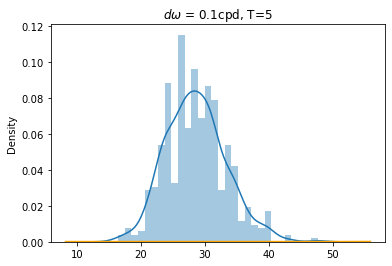

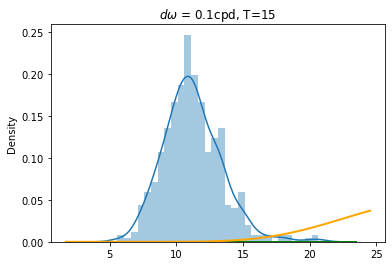

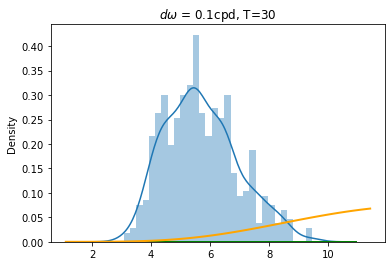

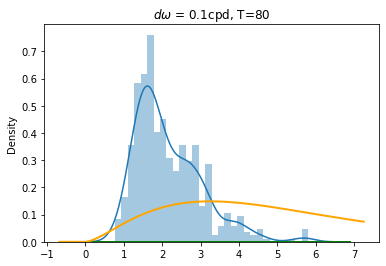

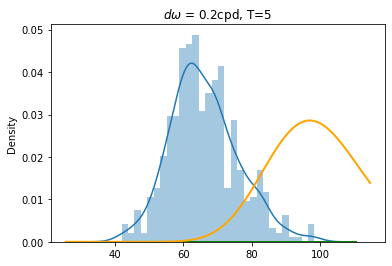

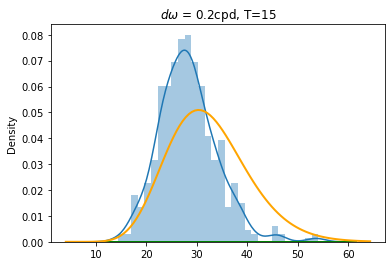

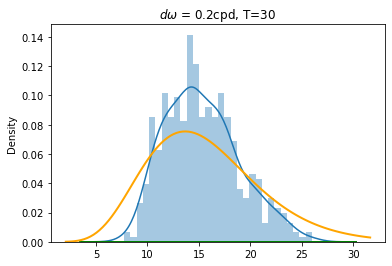

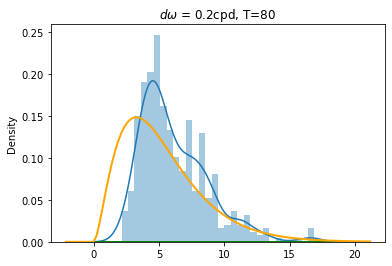

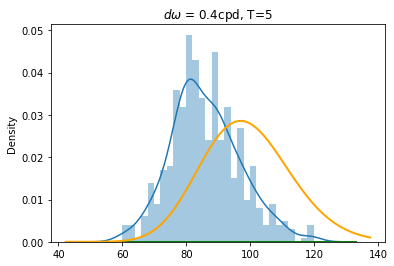

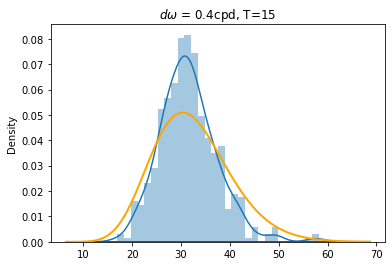

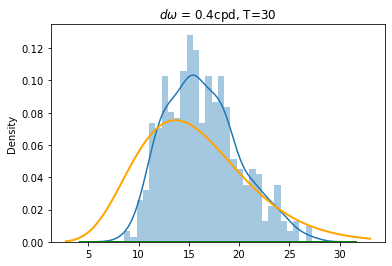

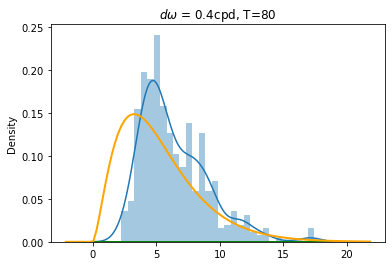

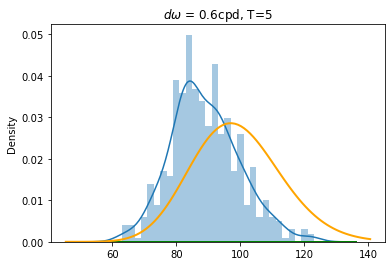

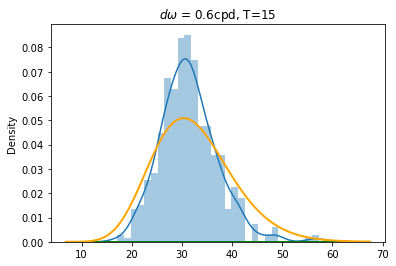

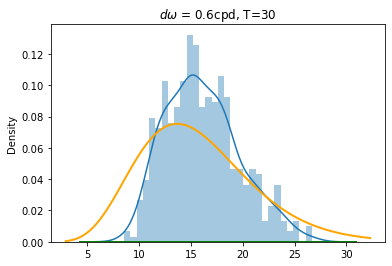

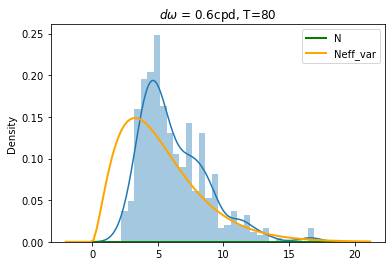

In [86]:
for dband in sigma0_hat.bandwidth:
    for t in sigma0_hat.T:
        plt.figure()
        ax = sns.distplot(sigma0_hat.high_MS_demodulated.sel(bandwidth=dband,T=t
                                                            )*(Neff_var.sel(T=t)-1)/0.01, bins=30, norm_hist=True)
        def add_dist(Neff, label, color):
            x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
            x_pdf = np.linspace(x0, x1, 100)
            y_pdf = stats.chi2.pdf(x_pdf, Neff-1, loc=0, scale=1)
            ax.plot(x_pdf, y_pdf, color=color, lw=2, label=label)                                                     

        add_dist(N, "N", "green")
        add_dist(Neff_var.sel(T=t), "Neff_var", "orange")
        #add_dist(Neff_exact, "Neff_exact", "red")
        #add_dist(Neff_bh, "Neff_bailey", "red")
        #add_dist(Neff_bretherton, "Neff_bretherton", "brown")
        ax.set_title(r'$d\omega$ = %scpd, T=%s'%(dband.values,t.values))
ax.legend()

In [97]:
def generate_CI(Ne,dband, alpha=0.1):
    fig, axs = plt.subplots(1,T.size,figsize=(5*T.size,5))
    for i, t in enumerate(sigma0_hat.T.values):
        ds = sigma0_hat.sel(bandwidth=dband,T=t)
        ds["sigma0_lower"] = (Ne.sel(T=t)-1)*ds.high_MS_demodulated/stats.chi2.ppf(1-alpha/2, Ne.sel(T=t)-1)
        ds["sigma0_upper"] = (Ne.sel(T=t)-1)*ds.high_MS_demodulated/stats.chi2.ppf(alpha/2, Ne.sel(T=t)-1)

        _sigma0_hat = ds.sortby("high_MS_demodulated")

    

    # not working ... ?
    #ax.fill_between(_ds.mu_lower.values, _ds.mu_upper.values)
    #ax.fill_between(_ds.mu_upper.values, _ds.mu_lower.values)

        ax=axs[i]
        ax.plot(_sigma0_hat.sigma0_lower, "0.5", lw=2)
        ax.plot(_sigma0_hat.sigma0_upper, "0.5", lw=2)

        ax.plot(_sigma0_hat.high_MS_demodulated, "k", lw=2)
        ax.grid()

        percent_success = (_sigma0_hat.where( (_sigma0_hat.sigma0_upper>0.01) & (_sigma0_hat.sigma0_lower<0.01), drop=True )
                           .draw.size
                           /_sigma0_hat.draw.size
                          )
        ax.set_title(f"percent success = {percent_success:.2f}")
#        print(f"percent success = {percent_success:.2f}")

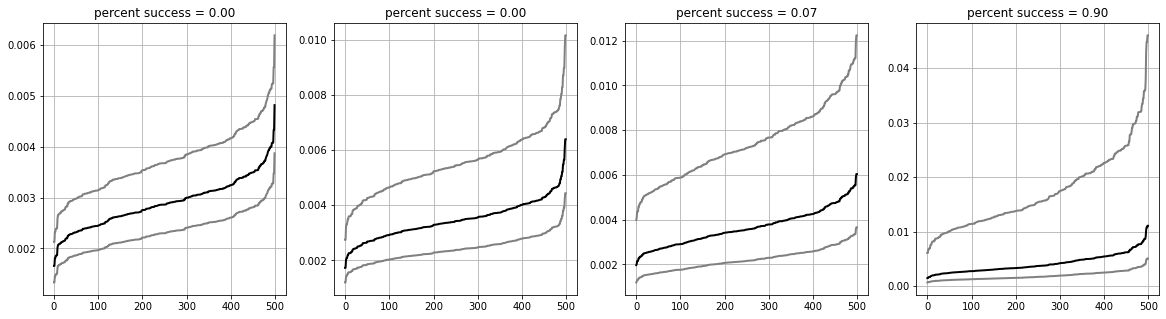

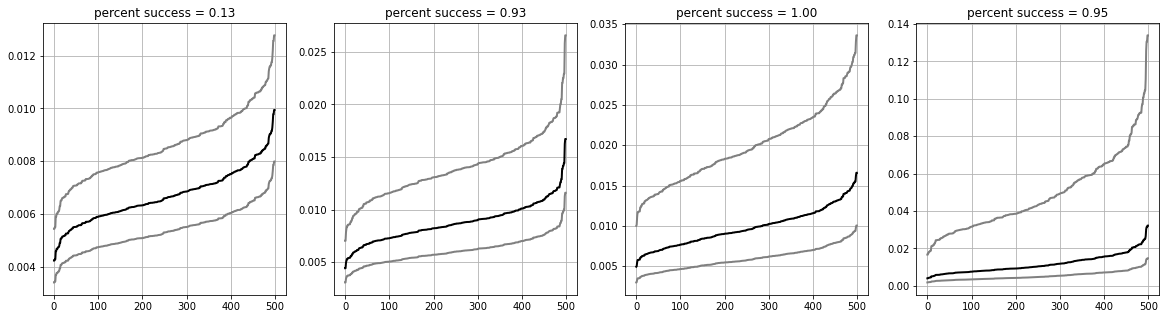

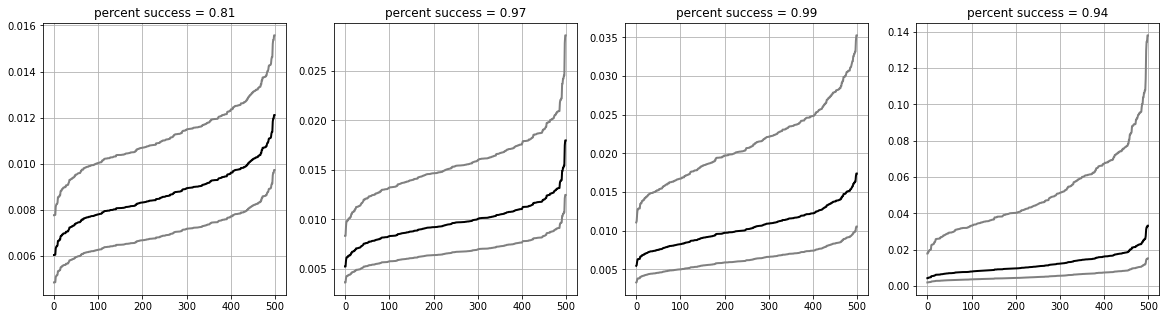

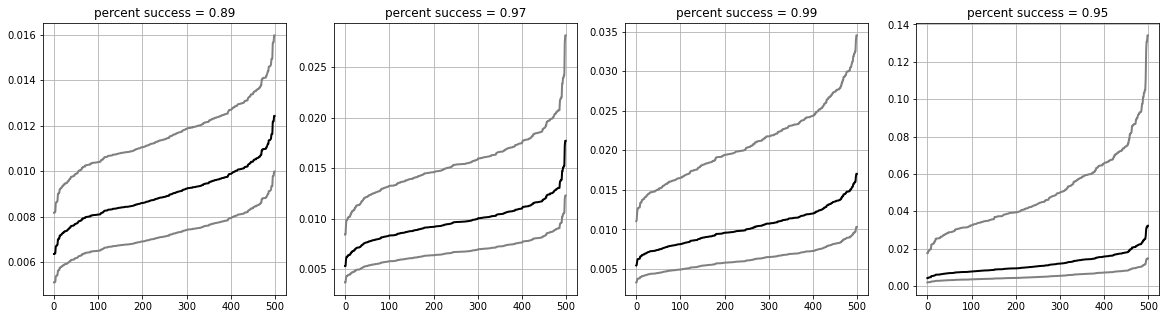

In [98]:
for db in sigma0_hat.bandwidth:
    generate_CI(Neff_var,db)

In [99]:
cluster.close()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/